In [1]:
import tensorflow as tf
import os
import time
from get_mnist import read_data_sets
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
mnist = read_data_sets("./mnist", one_hot=True, dtype='float32')

Extracting ./mnist/train-images-idx3-ubyte.gz
Extracting ./mnist/train-labels-idx1-ubyte.gz
Extracting ./mnist/t10k-images-idx3-ubyte.gz
Extracting ./mnist/t10k-labels-idx1-ubyte.gz


In [3]:
with tf.name_scope("inputs"):
    x = tf.placeholder(tf.float32, [None, 784], name="input")
    y = tf.placeholder(tf.float32, [None, 10], name="output")

# Define network
Input is 784 elemnts wide (full image). Make a fully connected network with a 50 element hidden layer.

This isn't a particularly good network, but it serves to illustrate some tensorflow things.

In [125]:
d_prob = tf.placeholder(tf.float32, 1)

def bostrom_dropout(x, prob, n_bunch):
    n_batch = tf.shape(x)[0]
    bunch_size = tf.shape(x)[1] / n_bunch
    rs_size = tf.pack([n_batch, n_bunch, bunch_size])
    x_rs = tf.reshape(x, rs_size)
    noise_shape = tf.pack([n_batch, n_bunch,1])
    x_do = tf.nn.dropout(x_rs, prob, noise_shape=noise_shape)
    x_do_f = tf.reshape(x_do, tf.shape(x))
    return x_do_f

W1 = tf.Variable(tf.random_normal([784, 50]), name="W1")
b1 = tf.Variable(tf.random_normal([50]), name="b1")
W2 = tf.Variable(tf.random_normal([50, 50]), name="W2")
b2 = tf.Variable(tf.random_normal([50]), name="b2")
W3 = tf.Variable(tf.random_normal([50, 10]), name="W3")
b3 = tf.Variable(tf.random_normal([10]), name="b3")

h1 = tf.tanh(tf.matmul(x, W1) + b1)
# dh1 = bostrom_dropout(h1, d_prob, 5)
dh1 = dropout(h1, d_prob)
h2 = tf.tanh(tf.matmul(h1, W2) + b2)
# dh2 = bostrom_dropout(h2, d_prob, 5)
dh2 = dropout(h2, d_prob)
output = tf.nn.softmax(tf.matmul(dh2, W3) + b3)
    
tf.histogram_summary("w1", W1)
tf.histogram_summary("b1", b1)
tf.histogram_summary("w2", W2)
tf.histogram_summary("b2", b2)
tf.histogram_summary("output", output)

# with tf.name_scope("loss"):
cross_entropy = -tf.reduce_sum(y*tf.log(output + 1e-9))
xentropy = tf.scalar_summary("xentropy", cross_entropy)
    
# with tf.name_scope("train"):
train_step = tf.train.AdamOptimizer(0.01).minimize(cross_entropy)

# with tf.name_scope("test"):
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(output,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
accuracy_summary = tf.scalar_summary("accuracy", accuracy)

In [126]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())
for i in range(10000):
    x_tr_, y_tr_ = mnist.train.next_batch(100)
    sess.run(train_step, feed_dict={x: x_tr_, y: y_tr_, d_prob:[0.5]})
    if i % 1000 == 0:
        x_te_, y_te_ = mnist.validation.next_batch(100)
        print "{}% correct".format(sess.run(100*accuracy, feed_dict={x: x_te_, y: y_te_, d_prob:[1.0]}))

14.0% correct
93.0% correct
93.0% correct
95.0% correct
93.0% correct
93.0% correct
94.0% correct
95.0% correct
95.0% correct
98.0% correct


In [127]:
def draw_layer(a, u, l):
    node_top = np.linspace(-1, 1, a.shape[1])
    node_bot = np.linspace(-1, 1, a.shape[0])
    max_a = np.max(np.abs(a))
    thick_a = np.abs(a) >= (max_a * u)
    thin_a = np.logical_and(np.abs(a) > (max_a * l), np.abs(a) < (max_a * u))
    thick_b, thick_t = np.where(thick_a)
    thin_b, thin_t = np.where(thin_a)
    thick_x = reduce(lambda x, y: x+y, [[node_top[t], node_bot[b]] for t, b in zip(thick_t, thick_b)])
    thin_x = reduce(lambda x, y: x+y, [[node_top[t], node_bot[b]] for t, b in zip(thin_t, thin_b)])
    thick_y = [1,-1] * len(thick_b)
    thin_y = [1,-1] * len(thin_b)
    
    plt.figure(figsize=(7,7), dpi=500)
    plt.scatter(node_bot, [-1] * a.shape[0])
    plt.scatter(node_top, [1] * a.shape[1])
    plt.plot(thin_x, thin_y, 'b', linewidth=0.05)
    plt.plot(thick_x, thick_y, 'b', linewidth=1)
    plt.axis([-1.3, 1.3, -1.3, 1.3])

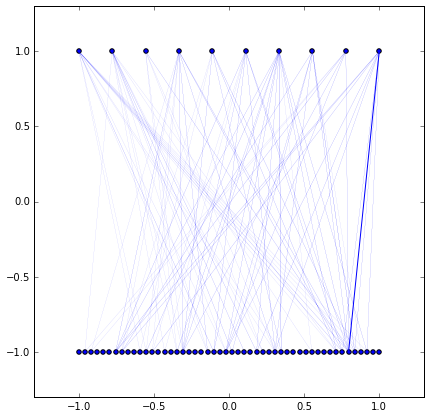

In [130]:
draw_layer(sess.run(W3), 1.0, 0.5)

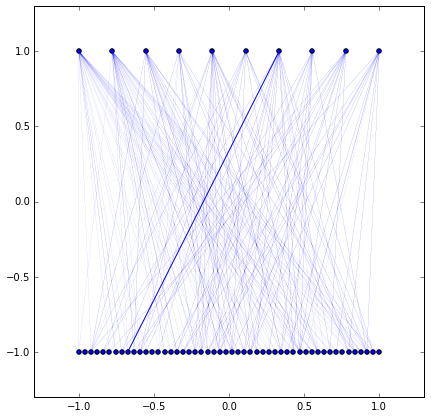

In [92]:
tf.nn.dropout?

In [125]:
n_bunch = 2
x = tf.random_normal([10,4])
n_batch = tf.shape(x)[0]
bunch_size = tf.shape(x)[1] / n_bunch
rs_size = tf.pack([n_batch, n_bunch, bunch_size])
x_rs = tf.reshape(x, rs_size)
noise_shape = tf.pack([n_batch, n_bunch,1])
x_do = tf.nn.dropout(x_rs, 0.5, noise_shape=noise_shape)
x_do_f = tf.reshape(x_do, tf.shape(x))

In [126]:
sess.run(x_do_f)

array([[ 0.93302035,  1.24096262,  0.77105963,  0.96474093],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [-0.        ,  0.        , -0.        , -0.        ],
       [ 0.67098564,  0.15556054,  1.33072639,  1.16448319],
       [ 3.66957259,  0.07281066,  0.        ,  0.        ],
       [-0.        , -0.        ,  2.460989  , -1.09019983],
       [ 0.        , -0.        ,  0.        ,  0.        ],
       [ 0.11812168,  3.23641706, -0.        , -0.        ],
       [ 0.36610326,  2.34622169,  0.        , -0.        ],
       [ 0.        , -0.        ,  2.87016463,  1.42100835]], dtype=float32)